In [1]:
# Step-2:
#### 1. Image Contrast
#### 2. Data Split (Train(80), Validation(20))
#### 3. Transfer learning

In [51]:
pip install tensorflow-addons --user

  Using cached tensorflow_addons-0.20.0-cp39-cp39-win_amd64.whl (746 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\v4run\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import tensorflow as tf
import keras
from imageContrast import img_cont
from skimage import exposure
from pylab import *
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from imageCropping import crop_img
import tensorflow_addons as tfa

C:\Users\v4run\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
trainingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/TrainingDataset'

In [3]:
def imgContrastPreprocess(images, labels):
    equalized_images = tf.map_fn(lambda img: tf.py_function(img_cont, [img], Tout=tf.float32), images, fn_output_signature=tf.float32)
    return equalized_images, labels

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training'
)

Found 9625 files belonging to 2 classes.
Using 7700 files for training.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    trainingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation'
)

Found 9625 files belonging to 2 classes.
Using 1925 files for validation.


In [6]:
trainDataset = train_data.map(imgContrastPreprocess).repeat()

In [7]:
validDataset = val_data.map(imgContrastPreprocess)

In [8]:
# Model Structure
# parallel branches and dilated convolution using the Keras Functional API

In [9]:
input_img = Input(shape=(256,256,3))

conv1 = Conv2D(32,(3,3), activation = 'relu', padding='same')(input_img)
conv1 = MaxPooling2D((2,2), padding='same')(conv1)

conv2 = Conv2D(64,(3,3), activation = 'relu', padding='same')(conv1)
conv2 = MaxPooling2D((2,2), padding='same')(conv2)

conv3 = Conv2D(128,(3,3), activation = 'relu', padding='same')(conv2)
conv3 = MaxPooling2D((2,2), padding='same')(conv3)

# Parallel branches
pbranch1 = Conv2D(256,(3,3), activation = 'relu', padding='same')(conv3)
pbranch2 = Conv2D(256,(5,5), activation = 'relu', padding='same')(conv3)
pbranch3 = Conv2D(256,(7,7), activation = 'relu', padding='same')(conv3)

# Concatenate
concatenateBranch = concatenate([pbranch1,pbranch2,pbranch3], axis=-1) #fix this to 3 or -1

# Dilated convulation
dilatedConv = Conv2D(256,(3,3), activation = 'relu', padding='same', dilation_rate=2)(concatenateBranch)
dilatedConv = MaxPooling2D((2,2),padding = 'same')(dilatedConv)

# Flatten and fully connected layers
flat = Flatten()(dilatedConv)
dense1 = Dense(256,activation='relu')(flat)
dense2 = Dense(1,activation='sigmoid')(dense1)

model = Model(inputs=input_img, outputs=dense2)
f1Score = tfa.metrics.F1Score(num_classes=1,average='macro',threshold=0.5)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1Score])
earlyStopping = EarlyStopping(monitor='val_f1_score', patience=10, verbose=1, mode='max')
checkPoint = ModelCheckpoint(
    'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/parallelBranch.h5',
    monitor = 'val_f1_score',
    verbose = 1,
    save_best_only=True,
    mode='max'
)
history = model.fit(
    trainDataset,
    steps_per_epoch=floor(7700//32),
    epochs=100,
    validation_data=validDataset,
    validation_steps=floor(1925//32),
    callbacks=[earlyStopping,checkPoint]
)

loss, accuracy = model.evaluate(validDataset,steps=floor(1925//32))

Epoch 1/100
240/240 [==============================] - ETA: 0s - loss: 0.6972 - f1_score: 0.6070
Epoch 1: val_f1_score improved from -inf to 0.76456, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\parallelBranch.h5
240/240 [==============================] - 1471s 6s/step - loss: 0.6972 - f1_score: 0.6070 - val_loss: 0.5471 - val_f1_score: 0.7646
Epoch 2/100
240/240 [==============================] - ETA: 0s - loss: 0.4527 - f1_score: 0.7968
Epoch 2: val_f1_score improved from 0.76456 to 0.82945, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\parallelBranch.h5
240/240 [==============================] - 1470s 6s/step - loss: 0.4527 - f1_score: 0.7968 - val_loss: 0.3813 - val_f1_score: 0.8294
Epoch 3/100
240/240 [==============================] - ETA: 0s - loss: 0.3257 - f1_score: 0.8652
Epoch 3: val_f1_score improved from 0.82945 to 0.85298, saving model to C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models\paral

In [10]:
best_epochLocation = history.history['val_f1_score'].index(max(history.history['val_f1_score']))
best_epochLocation

25

In [11]:
best_history = {key: values[:best_epochLocation + 1] for key, values in history.history.items()}
best_history

{'loss': [0.6972348690032959,
  0.45274290442466736,
  0.3257076144218445,
  0.27941134572029114,
  0.25056684017181396,
  0.2252122461795807,
  0.19481481611728668,
  0.18034933507442474,
  0.1460055410861969,
  0.11262106895446777,
  0.08999554067850113,
  0.06040320172905922,
  0.0816098153591156,
  0.05922674760222435,
  0.04569590464234352,
  0.03313228860497475,
  0.023242687806487083,
  0.04489004239439964,
  0.03509550914168358,
  0.027895314618945122,
  0.01711767539381981,
  0.026335489004850388,
  0.02268919162452221,
  0.04209627956151962,
  0.007395180407911539,
  0.0021944954060018063],
 'f1_score': [0.6070189476013184,
  0.7967820763587952,
  0.8651615381240845,
  0.8895297646522522,
  0.9018071293830872,
  0.9117646813392639,
  0.9251439571380615,
  0.93001788854599,
  0.9436619877815247,
  0.9583927392959595,
  0.9643134474754333,
  0.9767623543739319,
  0.9693204164505005,
  0.9772607684135437,
  0.9835556149482727,
  0.9882782101631165,
  0.9927102327346802,
  0.9838

In [15]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/fourLayerModel.h5')

In [12]:
savedModel = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/parallelBranch.h5')

In [13]:
acc = best_history['f1_score']
loss = best_history['loss']
val_acc = best_history['val_f1_score']
val_loss = best_history['val_loss']

In [14]:
epoch = range(1, len(acc)+1)

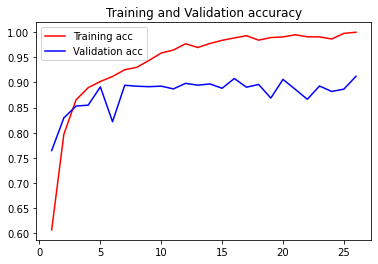

In [15]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

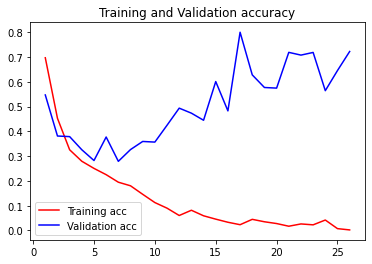

In [16]:
plt.plot(epoch, loss, 'r', label = 'Training acc')
plt.plot(epoch, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [17]:
# Test Data

In [18]:
testingDataPath = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2'

In [19]:
test_data = tf.keras.utils.image_dataset_from_directory(
    testingDataPath,
    seed=21,
    image_size=(256, 256),
    batch_size=32
)

Found 3553 files belonging to 2 classes.


In [20]:
#crop Data

In [21]:
def imgCropPreprocess(images,labels):
    cropped_images = tf.map_fn(lambda img: tf.py_function(crop_img, [img], Tout=tf.float32), images)
    return cropped_images,labels

In [22]:
testCropped_data = test_data.map(imgCropPreprocess)

In [23]:
a = testCropped_data.as_numpy_iterator()

In [24]:
img, label = a.next()

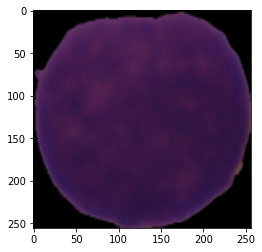

In [25]:
imshow(img[0])

In [26]:
testCont_data = testCropped_data.map(imgContrastPreprocess)

In [27]:
saved_model = tf.keras.models.load_model('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/parallelBranch.h5')

In [28]:
# prediction

In [29]:
y_predict = saved_model.predict(testCont_data)

112/112 [==============================] - 223s 2s/step


In [30]:
y_predict_binary = (y_predict>0.5).astype(int)

In [31]:
y_pred = np.round(y_predict).flatten()

In [32]:
y_predict_binary

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [33]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [34]:
y_true = np.concatenate([y for x, y in testCont_data], axis=0)

In [35]:
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)
f1Score = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1_score: {f1Score:.4f}')

Precision: 0.6885
Recall: 0.1368
f1_score: 0.2282


In [36]:
confusionMatrix = confusion_matrix(y_true, y_predict_binary)
print(confusionMatrix)

[[ 944  152]
 [2121  336]]


In [37]:
layer_names = [layer.name for layer in saved_model.layers if 'conv' in layer.name]
visualize_model = Model(inputs=saved_model.inputs, outputs=[saved_model.get_layer(name).output for name in layer_names])

In [38]:
a = testCont_data.as_numpy_iterator()

In [39]:
img1, label1 = a.next()

In [40]:
img10,label10 = img1[0],label1[0]

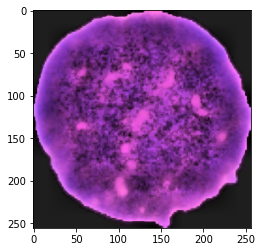

In [41]:
imshow(img10)

In [42]:
label10

1

In [43]:
img10 = np.expand_dims(img10,axis=0)

In [47]:
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [44]:
(saved_model.predict(img10)>0.5).astype(int)

1/1 [==============================] - 0s 181ms/step


array([[0]])

In [45]:
activations = visualize_model(img10)

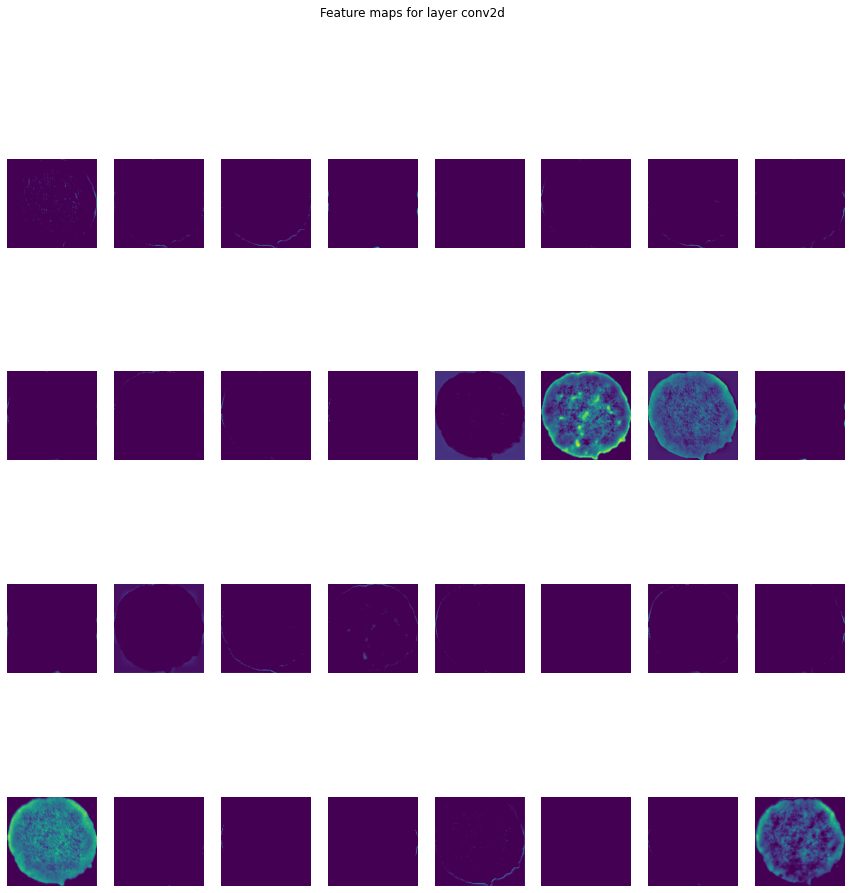

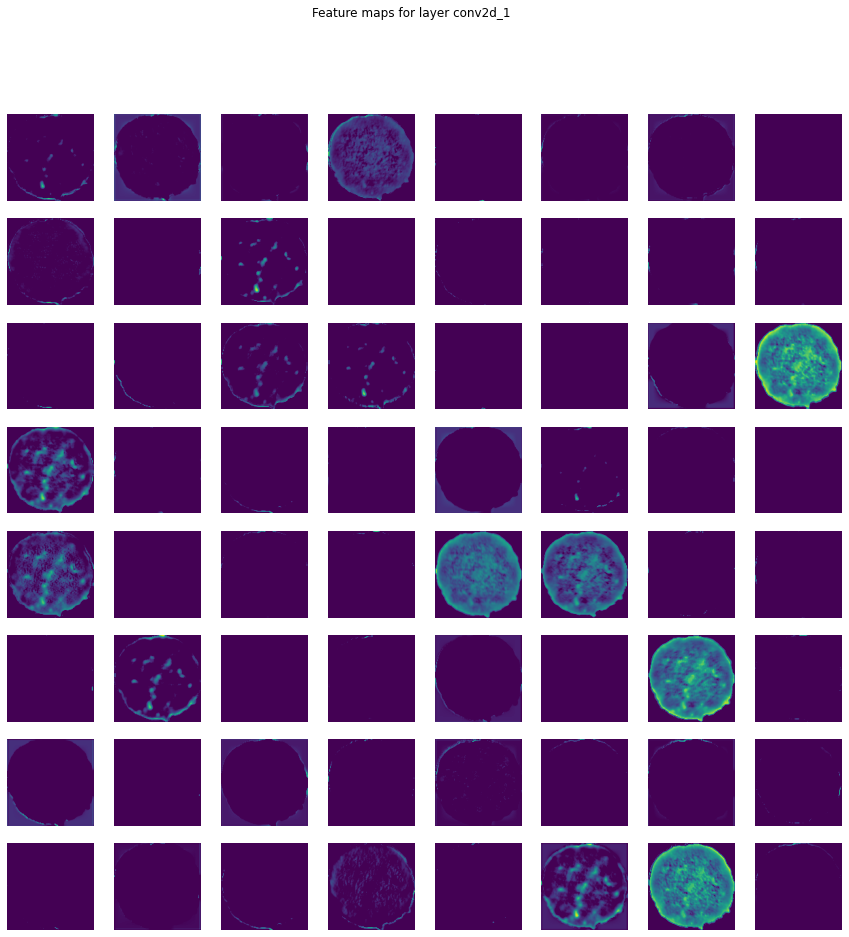

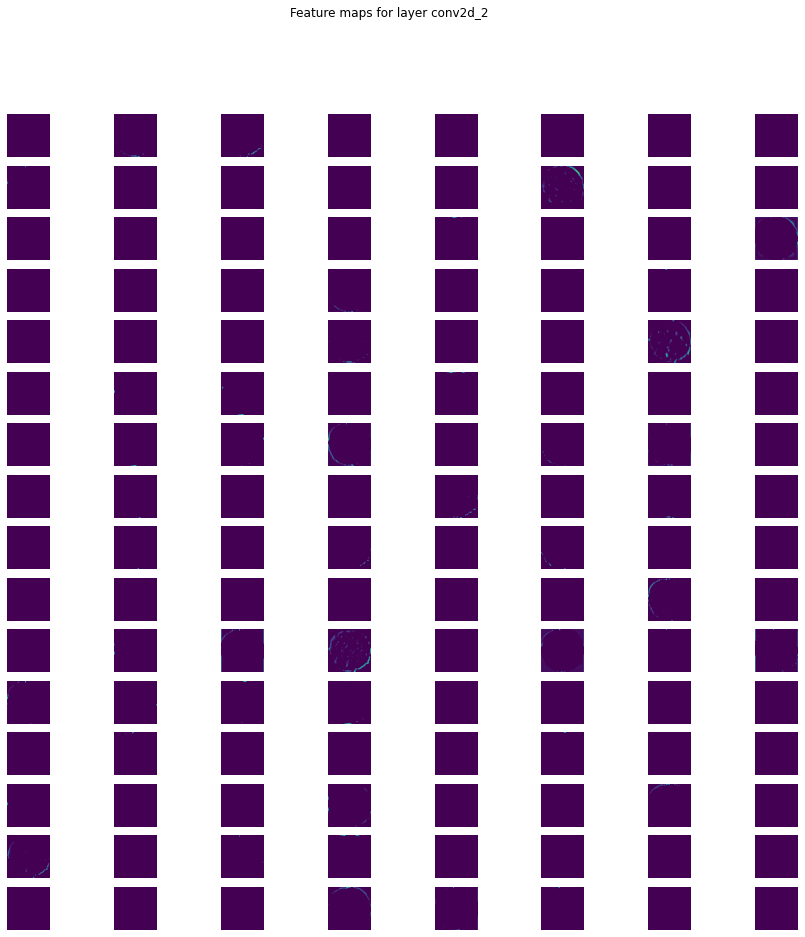

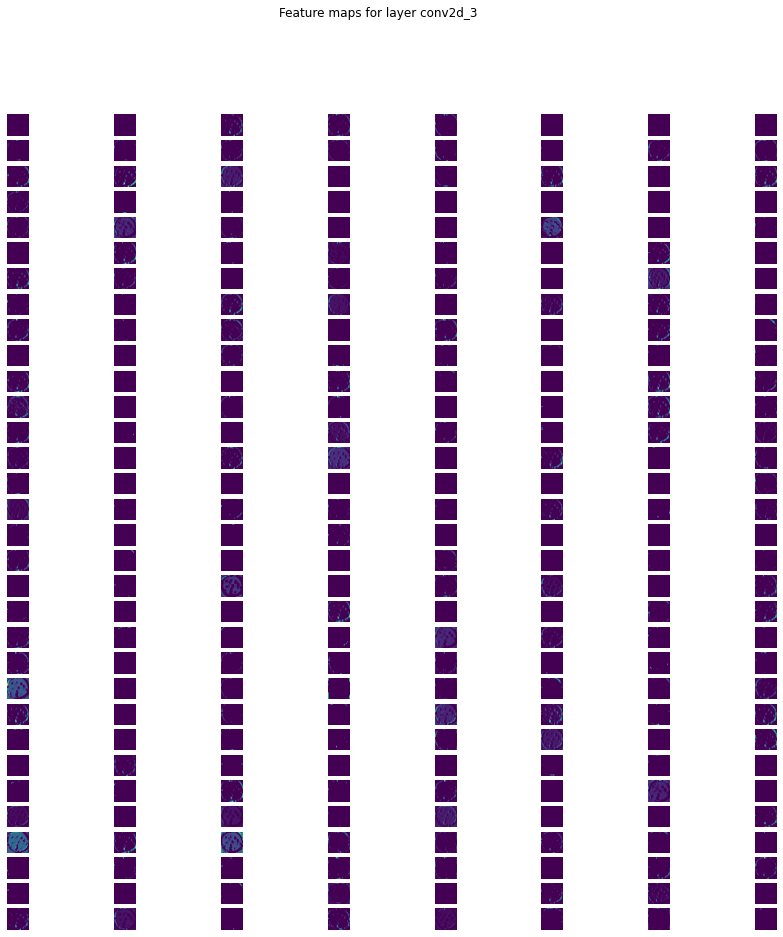

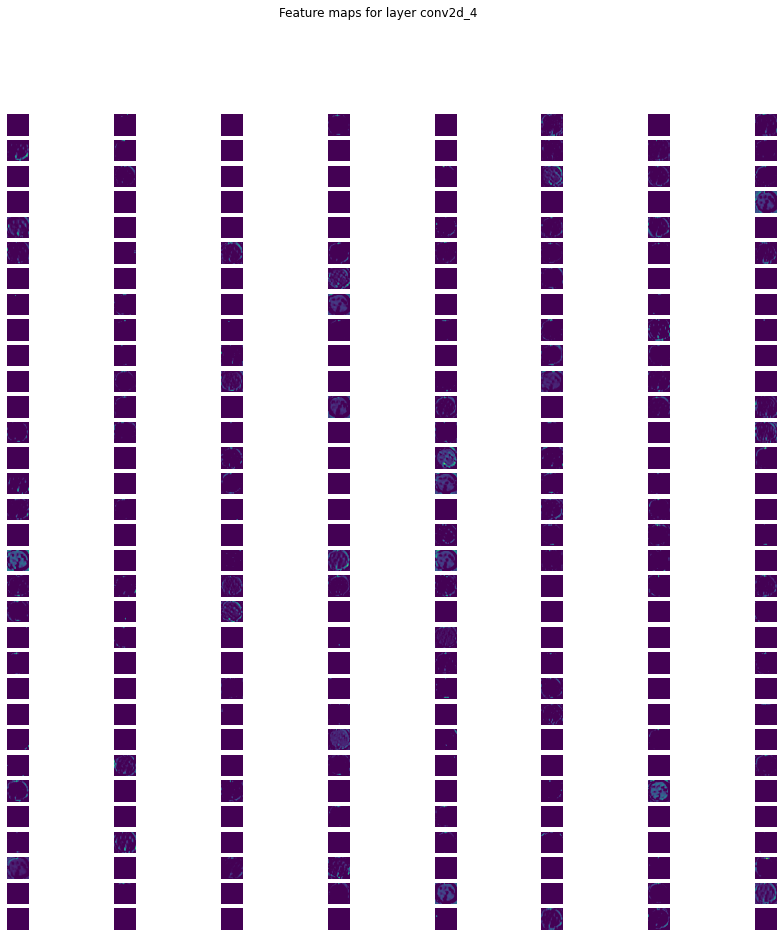

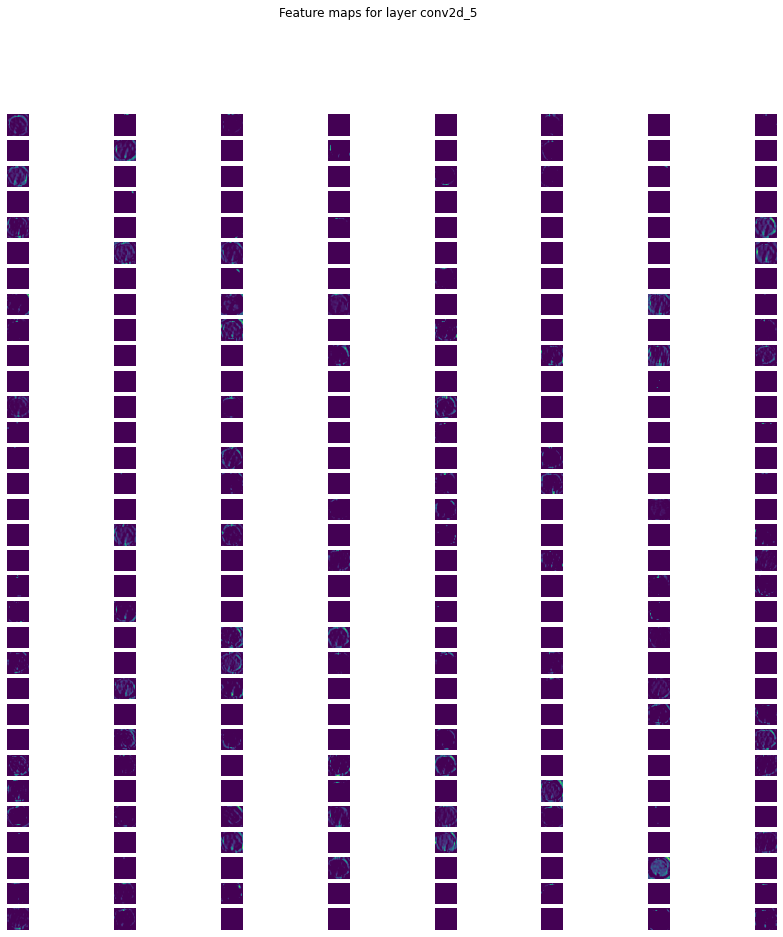

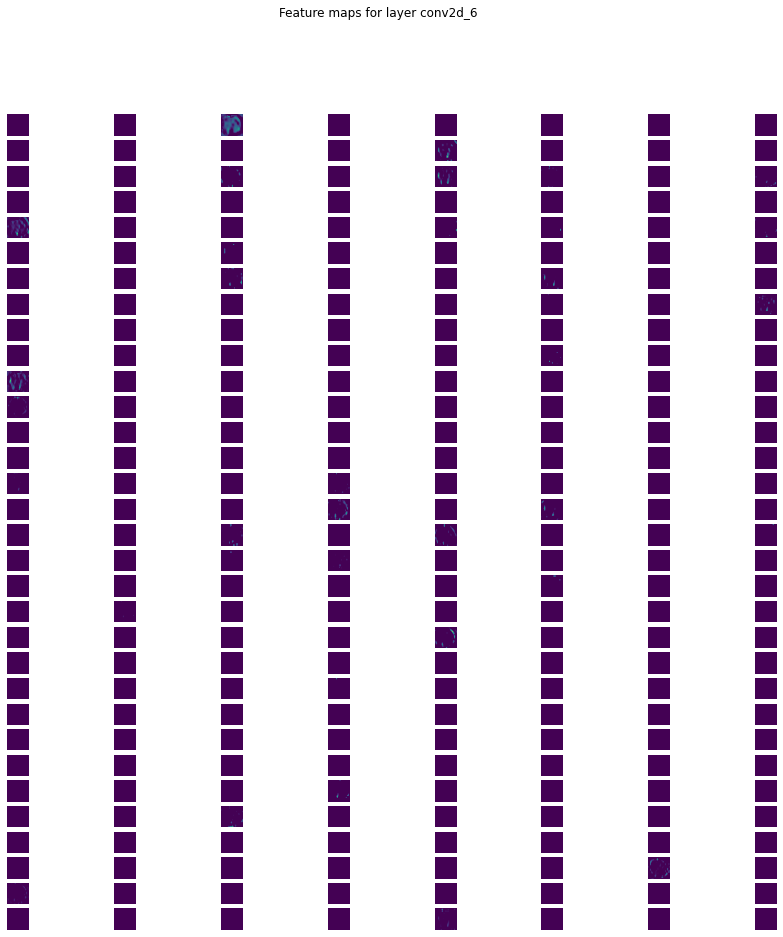

In [46]:
def display_feature_maps(activations, layer_names):
    for i, activation in enumerate(activations):
        layer_name = layer_names[i]
        num_filters = activation.shape[-1]

        # Calculate the number of rows and columns for the grid
        no_cols = 8
        grid_rows = num_filters // no_cols

        fig, axes = plt.subplots(grid_rows, no_cols, figsize=(15, 15))
        fig.suptitle(f"Feature maps for layer {layer_name}")

        for j in range(num_filters):
            ax = axes[j // no_cols, j % no_cols]
            ax.imshow(activation[0, :, :, j], cmap='viridis')
            ax.axis('off')

        plt.show()

# Call the function with the activations and layer names
display_feature_maps(activations, layer_names)